# Policy iteration

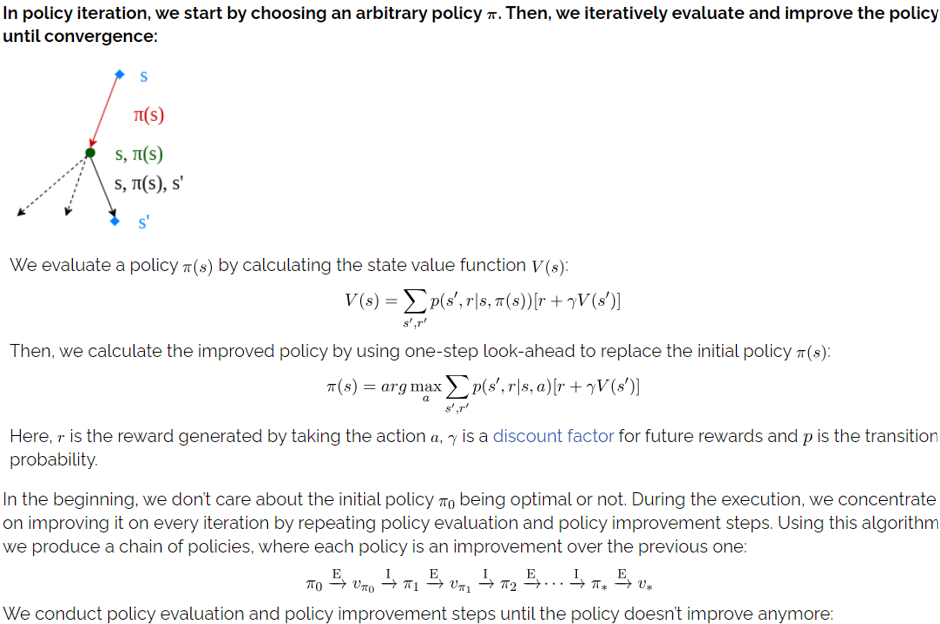

In [62]:
from IPython.display import Image

Image(filename="imgs/Policy iteration explication.png", width=850, height=600)

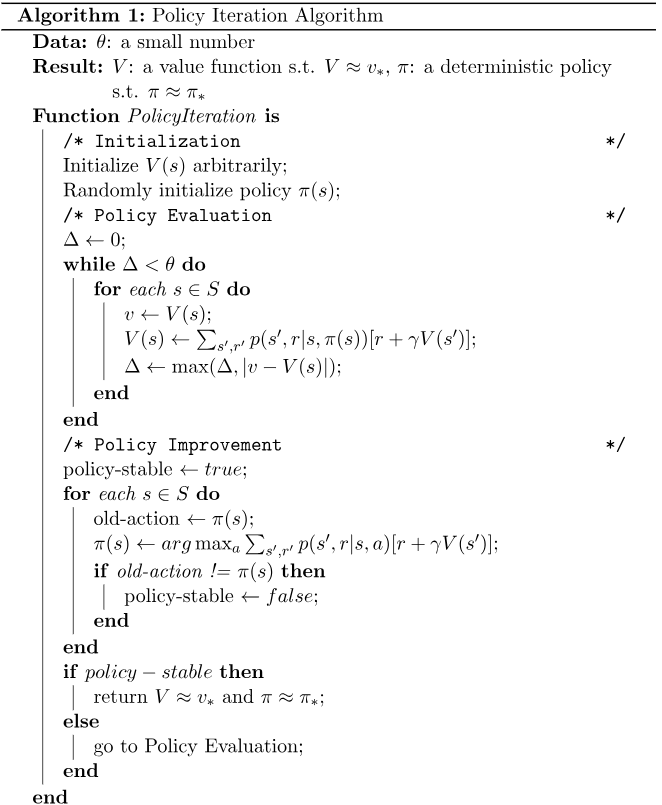

In [61]:
from IPython.display import Image

Image(filename="imgs/Policy Iteration.png", width=600, height=300)

# 1) No Trap Case

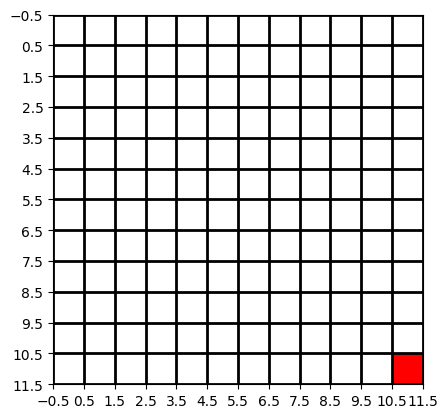

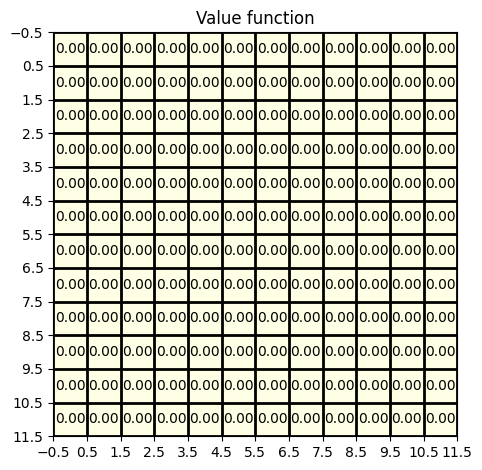

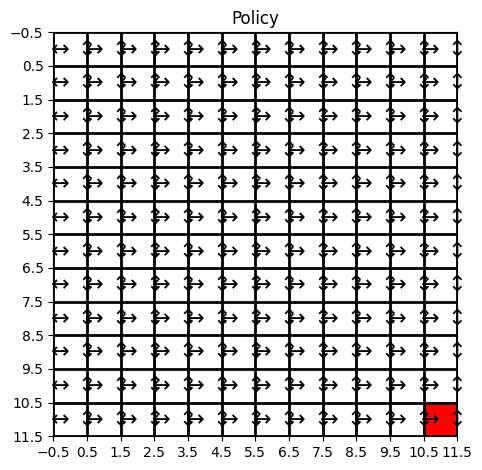


Iteration 1 of Policy Iteration algorithm


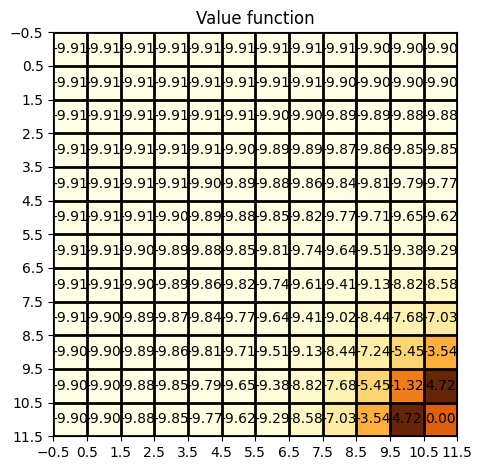


The Policy Evaluation algorithm converged after 45 iterations


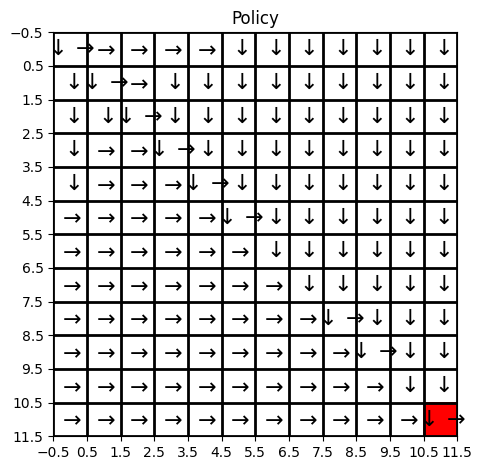


Iteration 2 of Policy Iteration algorithm


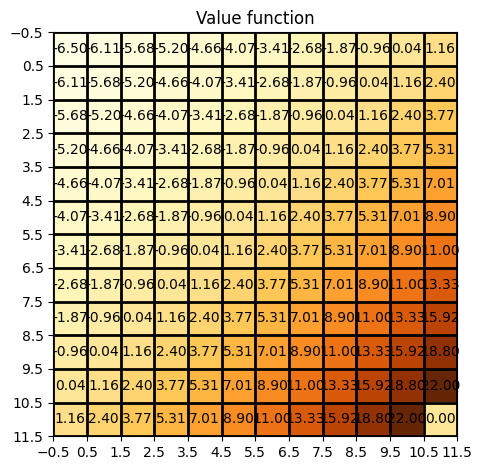


The Policy Evaluation algorithm converged after 23 iterations


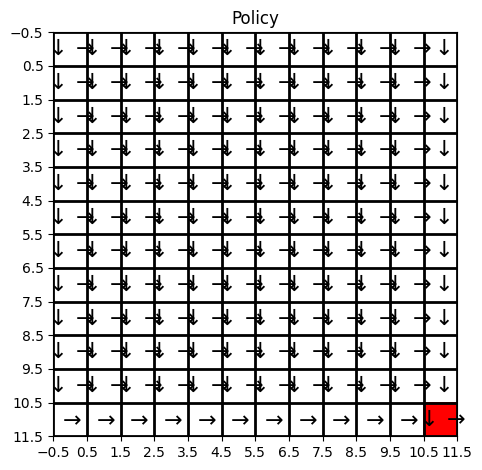


Iteration 3 of Policy Iteration algorithm


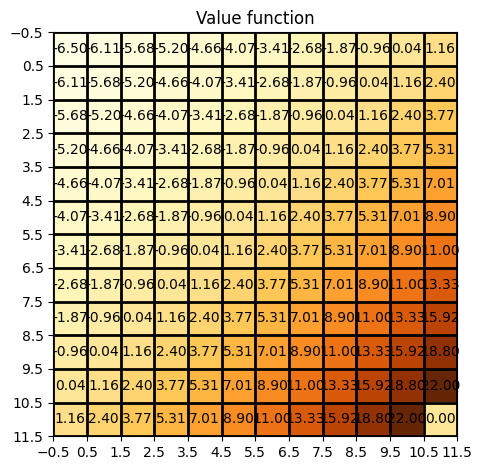


The Policy Evaluation algorithm converged after 1 iterations


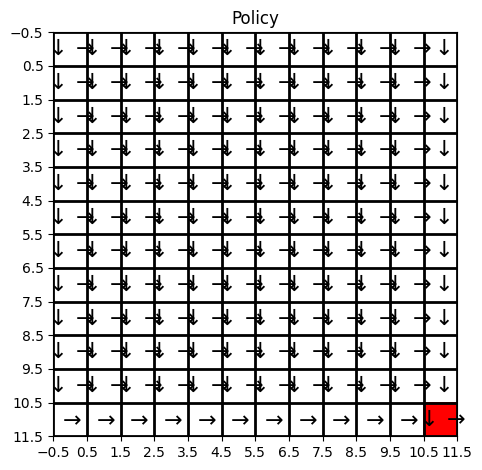


Policy Iteration algorithm converged after 3 steps


In [3]:
"""
    Famous grid world problem from Reinforcement Learning. We define an end cell and `barrier` cells. The latter have a more
    negative reward, and so must be avoided. The goal is for the agent to learn to travel to the end cell in the best
    way possible (maximum reward). For that we will apply the policy iteration algorihm.

    We are assuming that:
        * we start with the equiprobable policy; =  initially, the agent adopts a policy in which all possible actions have an equal probability of being selected.
        * when the action send us to a cell outside the grid, we will stay in the same cell.
"""


import argparse
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib import colors


class Environment:
    def __init__(self, n, actions, rewards, e_x, e_y):
        self.n = n
        self.actions = actions
        self.rewards = rewards
        self.e_x = e_x
        self.e_y = e_y


def policy_iteration(n, p_barrier, r_barrier, v0_val, gamma, theta, seed_nr):
    """Runs a simulation of the Policy Iteration (prediction + control) algorithm

    Args:
        n (int): length and width of the grid
        p_barrier (float): probability of a cell being a barrier
        r_barrier (int): reward for the barrier cells
        v0_val (int): initial value for the value function
        gamma (float): gamma parameter (between 0 and 1)
        theta (float): threshold parameter that defines when the change in the value function is negligible
        seed_nr (int): seed number (for reproducible results)
    """

    # Create initial environment
    env = build_grid(n, p_barrier, r_barrier, seed_nr)
    i = 0
    plot_grid(env)

    # Generate initial value function and policy
    v = get_init_v(n, v0_val, env.e_x, env.e_y)
    pi = get_equiprobable_policy(n)

    # Plot initial value function and policy
    plot_v_values(v, env.n)
    plot_optimal_actions(env, pi)

    policy_stable = False
    while not policy_stable:
        i += 1
        print("\nIteration {} of Policy Iteration algorithm".format(i))
        # Run the policy evaluation
        policy_evaluation(env, v, pi, gamma, theta)
        # Run the policy improvement algorithm
        policy_stable = policy_improvement(env, v, pi, gamma)
        plot_optimal_actions(env, pi)

    print("\nPolicy Iteration algorithm converged after {} steps".format(i))


def policy_evaluation(env, v, pi, gamma, theta):
    """Applies the policy evaluation algorithm.

    Args:
        env (Environment): gridworld environment
        v (array): numpy array representing the value function
        pi (array): numpy array representing the policy
        gamma (float): gamma parameter (between 0 and 1)
        theta (float): threshold parameter that defines when the change in the value function is negligible
    """

    delta = theta + 1
    iter = 0

    while delta >= theta:
        old_v = v.copy()
        delta = 0

        # Traverse all states
        for x in range(env.n):
            for y in range(env.n):
                # Run one iteration of the Bellman update rule for the value function
                bellman_update(env, v, old_v, x, y, pi, gamma)
                # Compute difference
                delta = max(delta, abs(old_v[x, y] - v[x, y]))

        iter += 1

    # Plot new value function
    plot_v_values(v, env.n)
    print("\nThe Policy Evaluation algorithm converged after {} iterations".format(iter))


def policy_improvement(env, v, pi, gamma):
    """Applies the Policy Improvement step.

    Args:
        env (Environment): gridworld environment
        v (array): numpy array representing the value function
        pi (array): numpy array representing the policy
        gamma (float): gamma parameter (between 0 and 1)
    """

    policy_stable = True

    # Iterate states
    for x in range(env.n):
        for y in range(env.n):
            old_pi = pi[x, y, :].copy()

            # Iterate all actions
            best_actions = []
            max_v = None
            for a in env.actions:
                # Compute next state
                s_prime_x, s_prime_y = get_next_state(x, y, a, env.n)
                # Get value
                curr_val = env.rewards[s_prime_x, s_prime_y] + gamma * v[s_prime_x, s_prime_y]

                if max_v is None:
                    max_v = curr_val
                    best_actions.append(a)
                elif curr_val > max_v:
                    max_v = curr_val
                    best_actions = [a]
                elif curr_val == max_v:
                    best_actions.append(a)

            # Define new policy
            define_new_policy(pi, x, y, best_actions, env.actions)

            # Check whether the policy has changed
            if not (old_pi == pi[x, y, :]).all():
                policy_stable = False

    return policy_stable


def bellman_update(env, v, old_v, x, y, pi, gamma):
    """Applies the Bellman update rule to the value function

    Args:
        env (Environment): grid world environment
        v (array): numpy array representing the value function
        old_v (array): numpy array representing the value function on the last iteration
        x (int): x value position of the current state
        y (int): y value position of the current state
        pi (array): numpy array representing the policy
        gamma (float): gamma parameter (between 0 and 1)
    """

    # The value function on the terminal state always has value 0
    if x == env.e_x and y == env.e_y:
        return None

    total = 0

    for a in env.actions:
        # Get next state
        s_prime_x, s_prime_y = get_next_state(x, y, a, env.n)

        total += pi[x, y, a] * (env.rewards[s_prime_x, s_prime_y] + gamma * old_v[s_prime_x, s_prime_y])

    # Update the value function
    v[x, y] = total


def define_new_policy(pi, x, y, best_actions, actions):
    """Defines a new policy given the new best actions.

    Args:
        pi (array): numpy array representing the policy
        x (int): x value position of the current state
        y (int): y value position of the current state
        best_actions (list): list with best actions
        actions (list): list of every possible action
    """

    prob = 1/len(best_actions)

    for a in actions:
        pi[x, y, a] = prob if a in best_actions else 0


def build_grid(n, p_barrier, r_barrier, seed_nr):
    """Build an NxN grid with start and end cells, as well as some barrier cells.

    Args:
        n (int): length and width of the grid
        p_barrier (float): probability of a cell being a barrier
        r_barrier (int): reward for the barrier cells

    Returns:
        env (Environment): grid world environment
    """

    # Define set of possible actions: go left (0), up (1), right (2) or down (4)
    actions = [0, 1, 2, 3]

    # Define start and end cells -> these will have value 0
    random.seed(seed_nr)
#     e_x = random.randrange(n)
#     e_y = random.randrange(n)
    e_x = n-1
    e_y = n-1

    # Define barrier cells -> these will have barrier reward. All other have -1 reward
#     rewards = (-1) * np.ones((n, n))
#     for i in range(n):
#         for j in range(n):
#             if i != e_x or j != e_y:
#                 p = random.uniform(0, 1)
#                 if p < p_barrier:
#                     rewards[i, j] = r_barrier
    rewards = (-1) * np.ones((n, n))
    rewards[11,11] = 2*(n-1)
#     for i in range(0,8):
#         for j in range(n):
#             if j==3:
#                 rewards[i, j] = r_barrier
                
#     for i in range(4,12):
#         for j in range(n):
#             if j==7:
#                 rewards[i, j] = r_barrier
                
 

    # Create environment
    env = Environment(n, actions, rewards, e_x, e_y)

    return env


def get_next_state(x, y, a, n):
    """Computes next state from current state and action.

    Args:
        x (int): x value of the current state
        y (int): y value of the current state
        a (int): action
        n (int): length and width of the grid

    Returns:
        s_prime_x (int): x value of the next state
        s_prime_y (int): y value of the next state
    """

    # Compute next state according to the action
    if a == 0:
        s_prime_x = x
        s_prime_y = max(0, y - 1)
    elif a == 1:
        s_prime_x = max(0, x - 1)
        s_prime_y = y
    elif a == 2:
        s_prime_x = x
        s_prime_y = min(n - 1, y + 1)
    else:
        s_prime_x = min(n - 1, x + 1)
        s_prime_y = y

    return s_prime_x, s_prime_y


def get_init_v(n, v0, e_x, e_y):
    """Defines initial value function v_0

    Args:
        n (int): length and width of the grid
        v0 (float): initial value for the value function (equal for every state)
        e_x (int): x value of the end cell
        e_y (int): y value of the end cell

    Returns:
        v0 (array): initial value function
    """

    v0 = v0 * np.ones((n, n))

    # Value function of terminal state must be 0
    v0[e_x, e_y] = 0

    return v0


def get_equiprobable_policy(n):
    """Defines the equiprobable policy. Policy is a matrix s.t.
        pi[x, y, a] = Pr[A = a | S = (x,y)]

    Actions are:
        * 0: go left
        * 1: go up
        * 2: go right
        * 3: go down

    Args:
        n (int): length and width of the grid

    Returns:
        pi (array): numpy array representing the equiprobably policy
    """

    pi = 1/4 * np.ones((n, n, 4))
    return pi



def plot_grid(env):
    """Plot grid

    Args:
        env (Environment): grid world environment
    """

    data = env.rewards.copy()
    data[env.e_x, env.e_y] = 10

    # create discrete colormap
    cmap = colors.ListedColormap(['grey', 'white', 'red'])
    bounds = [-11, -2, 0, 12]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots()
    ax.imshow(data, cmap=cmap, norm=norm)

    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-.5, env.n, 1))
    ax.set_yticks(np.arange(-.5, env.n, 1))

    plt.show()


def plot_v_values(v, n):
    """Plots the value function in each state as a grid.

    Args:
        v (array): numpy array representing the value function
        n (int):
    """

    fig, ax = plt.subplots()
    im = ax.imshow(v, cmap='YlOrBr', interpolation='nearest')

    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-.5, n, 1))
    ax.set_yticks(np.arange(-.5, n, 1))

    # Loop over data dimensions and create text annotations.
    for i in range(n):
        for j in range(n):
            text = ax.text(j, i, "{:.2f}".format(v[i, j]), ha="center", va="center", color="black")

    ax.set_title("Value function")
    fig.tight_layout()
    plt.show()


def plot_optimal_actions(env, pi):
    """Plots the optimal action to take in each state

    Args:
        env (Environment): grid world environment
        pi (array): numpy array indicating the probability of taking each action in each state
    """

    data = env.rewards.copy()
    data[env.e_x, env.e_y] = 10

    # create discrete colormap
    cmap = colors.ListedColormap(['grey', 'white', 'red'])
    bounds = [-11, -2, 0, 12]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots()
    ax.imshow(data, cmap=cmap, norm=norm)

    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-.5, env.n, 1))
    ax.set_yticks(np.arange(-.5, env.n, 1))

    # Loop over data dimensions and create text annotations.
    for i in range(env.n):
        for j in range(env.n):
            arrow = get_arrow(pi[i, j, :])
            text = ax.text(j, i, arrow, fontsize=16, ha="center", va="center", color="black")

    ax.set_title("Policy")
    fig.tight_layout()
    plt.show()


def get_arrow(prob_arr):
    """Returns the arrows that represent the highest probability actions.

    Args:
        prob_arr (array): numpy array denoting the probability of taking each action on a given state

    Returns:
        arrow (str): string denoting the most probable action(s)
    """

    best_actions = np.where(prob_arr == np.amax(prob_arr))[0]
    if len(best_actions) == 1:
        if 0 in best_actions:
            return r"$\leftarrow$"
        if 1 in best_actions:
            return r"$\uparrow$"
        if 2 in best_actions:
            return r"$\rightarrow$"
        else:
            return r"$\downarrow$"

    elif len(best_actions) == 2:
        if 0 in best_actions and 1 in best_actions:
            return r"$\leftarrow \uparrow$"
        elif 0 in best_actions and 2 in best_actions:
            return r"$\leftrightarrow$"
        elif 0 in best_actions and 3 in best_actions:
            return r"$\leftarrow \downarrow$"
        elif 1 in best_actions and 2 in best_actions:
            return r"$\uparrow \rightarrow$"
        elif 1 in best_actions and 3 in best_actions:
            return r"$\updownarrow$"
        elif 2 in best_actions and 3 in best_actions:
            return r"$\downarrow \rightarrow$"

    elif len(best_actions) == 3:
        if 0 not in best_actions:
            return r"$\updownarrow \rightarrow$"
        elif 1 not in best_actions:
            return r"$\leftrightarrow \downarrow$"
        elif 2 not in best_actions:
            return r"$\leftarrow \updownarrow$"
        else:
            return r"$\leftrightarrow \uparrow$"

    else:
        return r"$\leftrightarrow \updownarrow$"



if __name__ == "__main__":
    # Specify arguments
    args_list = [
        "--n", "12",
        "--p_barrier", "0.1",
        "--r_barrier",  str(-2 * (12 - 1)),
        "--v0_val", "0",
        "--gamma", "0.9",
        "--theta", "0.01",
        "--seed_nr", "123"
    ]

    # Parse arguments
    parser = argparse.ArgumentParser()
    for i in range(0, len(args_list), 2):
        parser.add_argument(args_list[i], type=type(eval(args_list[i+1])))
    args = parser.parse_args(args_list)

    # Run policy iteration with specified arguments
    policy_iteration(args.n, args.p_barrier, args.r_barrier, args.v0_val, args.gamma, args.theta, args.seed_nr)

# 2) With Trap Case

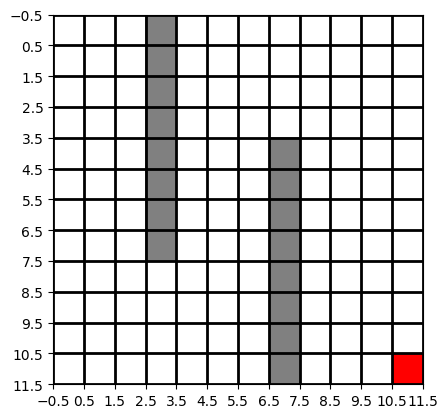

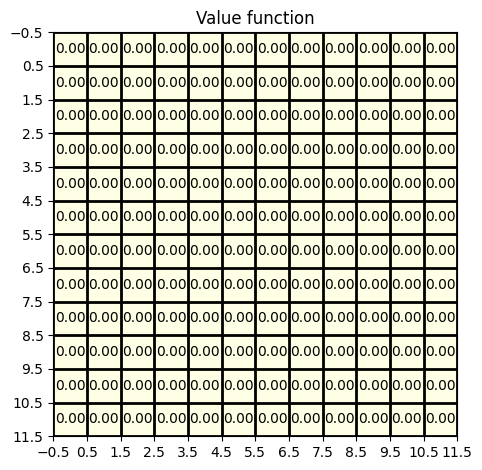

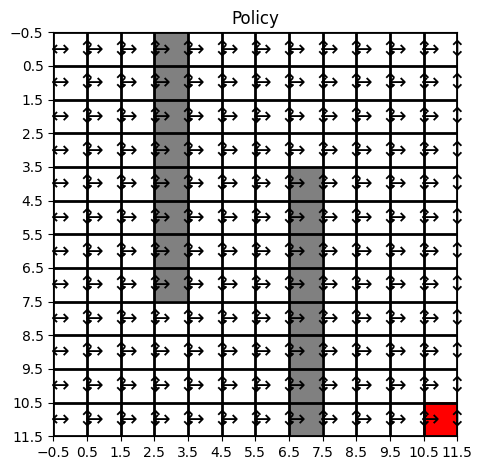


Iteration 1 of Policy Iteration algorithm


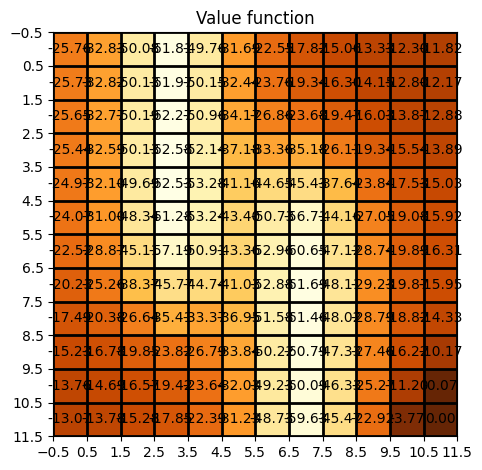


The Policy Evaluation algorithm converged after 58 iterations


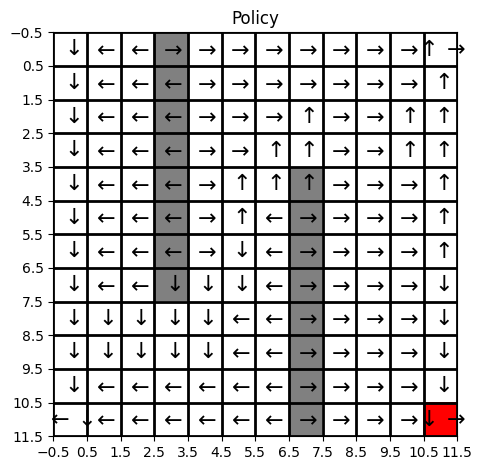


Iteration 2 of Policy Iteration algorithm


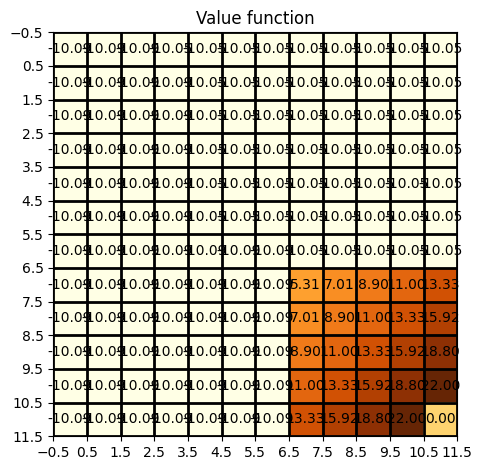


The Policy Evaluation algorithm converged after 34 iterations


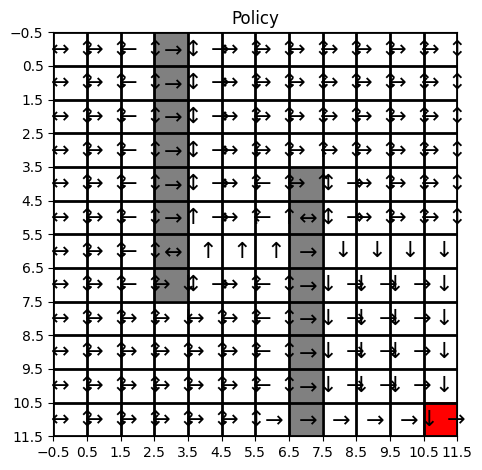


Iteration 3 of Policy Iteration algorithm


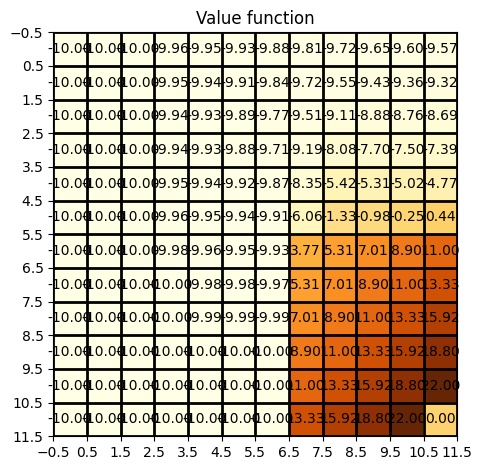


The Policy Evaluation algorithm converged after 28 iterations


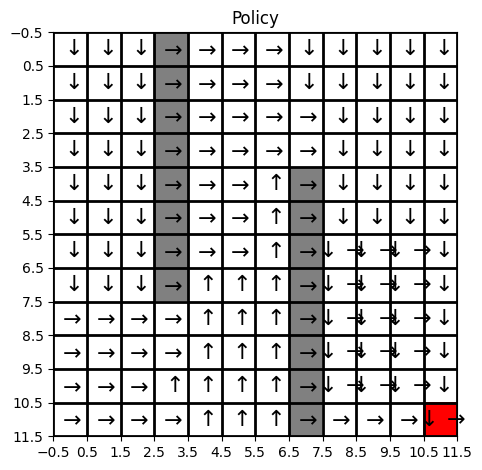


Iteration 4 of Policy Iteration algorithm


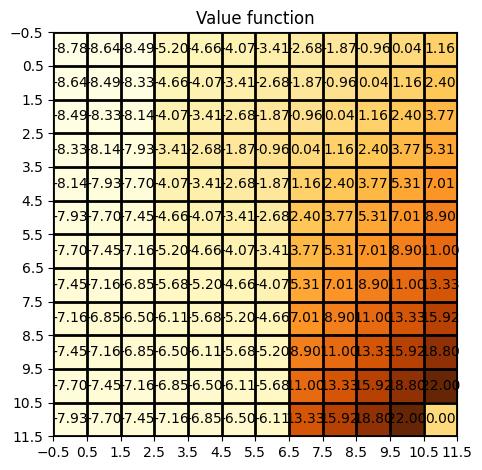


The Policy Evaluation algorithm converged after 25 iterations


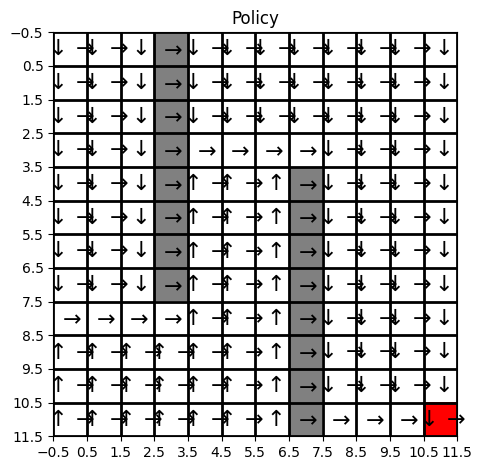


Iteration 5 of Policy Iteration algorithm


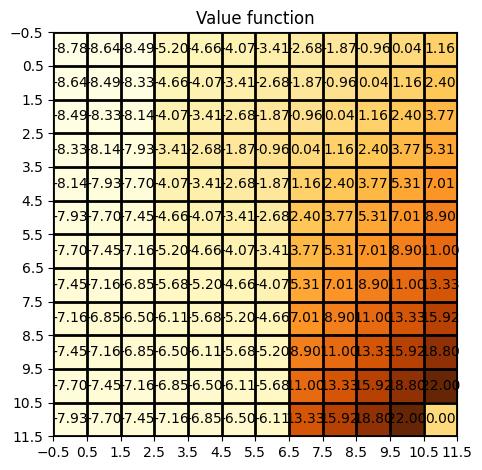


The Policy Evaluation algorithm converged after 1 iterations


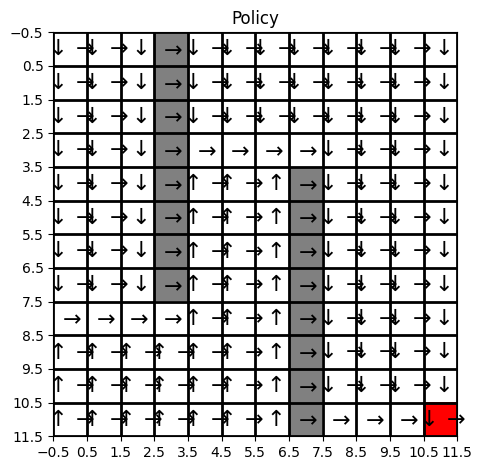


Policy Iteration algorithm converged after 5 steps


In [4]:
"""
    Famous grid world problem from Reinforcement Learning. We define an end cell and `barrier` cells. The latter have a more
    negative reward, and so must be avoided. The goal is for the agent to learn to travel to the end cell in the best
    way possible (maximum reward). For that we will apply the policy iteration algorihm.

    We are assuming that:
        * we start with the equiprobable policy; =  initially, the agent adopts a policy in which all possible actions have an equal probability of being selected.
        * when the action send us to a cell outside the grid, we will stay in the same cell.
"""


import argparse
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib import colors


class Environment:
    def __init__(self, n, actions, rewards, e_x, e_y):
        self.n = n
        self.actions = actions
        self.rewards = rewards
        self.e_x = e_x
        self.e_y = e_y


def policy_iteration(n, p_barrier, r_barrier, v0_val, gamma, theta, seed_nr):
    """Runs a simulation of the Policy Iteration (prediction + control) algorithm

    Args:
        n (int): length and width of the grid
        p_barrier (float): probability of a cell being a barrier
        r_barrier (int): reward for the barrier cells
        v0_val (int): initial value for the value function
        gamma (float): gamma parameter (between 0 and 1)
        theta (float): threshold parameter that defines when the change in the value function is negligible
        seed_nr (int): seed number (for reproducible results)
    """

    # Create initial environment
    env = build_grid(n, p_barrier, r_barrier, seed_nr)
    i = 0
    plot_grid(env)

    # Generate initial value function and policy
    v = get_init_v(n, v0_val, env.e_x, env.e_y)
    pi = get_equiprobable_policy(n)

    # Plot initial value function and policy
    plot_v_values(v, env.n)
    plot_optimal_actions(env, pi)

    policy_stable = False
    while not policy_stable:
        i += 1
        print("\nIteration {} of Policy Iteration algorithm".format(i))
        # Run the policy evaluation
        policy_evaluation(env, v, pi, gamma, theta)
        # Run the policy improvement algorithm
        policy_stable = policy_improvement(env, v, pi, gamma)
        plot_optimal_actions(env, pi)

    print("\nPolicy Iteration algorithm converged after {} steps".format(i))


def policy_evaluation(env, v, pi, gamma, theta):
    """Applies the policy evaluation algorithm.

    Args:
        env (Environment): gridworld environment
        v (array): numpy array representing the value function
        pi (array): numpy array representing the policy
        gamma (float): gamma parameter (between 0 and 1)
        theta (float): threshold parameter that defines when the change in the value function is negligible
    """

    delta = theta + 1
    iter = 0

    while delta >= theta:
        old_v = v.copy()
        delta = 0

        # Traverse all states
        for x in range(env.n):
            for y in range(env.n):
                # Run one iteration of the Bellman update rule for the value function
                bellman_update(env, v, old_v, x, y, pi, gamma)
                # Compute difference
                delta = max(delta, abs(old_v[x, y] - v[x, y]))

        iter += 1

    # Plot new value function
    plot_v_values(v, env.n)
    print("\nThe Policy Evaluation algorithm converged after {} iterations".format(iter))


def policy_improvement(env, v, pi, gamma):
    """Applies the Policy Improvement step.

    Args:
        env (Environment): gridworld environment
        v (array): numpy array representing the value function
        pi (array): numpy array representing the policy
        gamma (float): gamma parameter (between 0 and 1)
    """

    policy_stable = True

    # Iterate states
    for x in range(env.n):
        for y in range(env.n):
            old_pi = pi[x, y, :].copy()

            # Iterate all actions
            best_actions = []
            max_v = None
            for a in env.actions:
                # Compute next state
                s_prime_x, s_prime_y = get_next_state(x, y, a, env.n)
                # Get value
                curr_val = env.rewards[s_prime_x, s_prime_y] + gamma * v[s_prime_x, s_prime_y]

                if max_v is None:
                    max_v = curr_val
                    best_actions.append(a)
                elif curr_val > max_v:
                    max_v = curr_val
                    best_actions = [a]
                elif curr_val == max_v:
                    best_actions.append(a)

            # Define new policy
            define_new_policy(pi, x, y, best_actions, env.actions)

            # Check whether the policy has changed
            if not (old_pi == pi[x, y, :]).all():
                policy_stable = False

    return policy_stable


def bellman_update(env, v, old_v, x, y, pi, gamma):
    """Applies the Bellman update rule to the value function

    Args:
        env (Environment): grid world environment
        v (array): numpy array representing the value function
        old_v (array): numpy array representing the value function on the last iteration
        x (int): x value position of the current state
        y (int): y value position of the current state
        pi (array): numpy array representing the policy
        gamma (float): gamma parameter (between 0 and 1)
    """

    # The value function on the terminal state always has value 0
    if x == env.e_x and y == env.e_y:
        return None

    total = 0

    for a in env.actions:
        # Get next state
        s_prime_x, s_prime_y = get_next_state(x, y, a, env.n)

        total += pi[x, y, a] * (env.rewards[s_prime_x, s_prime_y] + gamma * old_v[s_prime_x, s_prime_y])

    # Update the value function
    v[x, y] = total


def define_new_policy(pi, x, y, best_actions, actions):
    """Defines a new policy given the new best actions.

    Args:
        pi (array): numpy array representing the policy
        x (int): x value position of the current state
        y (int): y value position of the current state
        best_actions (list): list with best actions
        actions (list): list of every possible action
    """

    prob = 1/len(best_actions)

    for a in actions:
        pi[x, y, a] = prob if a in best_actions else 0


def build_grid(n, p_barrier, r_barrier, seed_nr):
    """Build an NxN grid with start and end cells, as well as some barrier cells.

    Args:
        n (int): length and width of the grid
        p_barrier (float): probability of a cell being a barrier
        r_barrier (int): reward for the barrier cells

    Returns:
        env (Environment): grid world environment
    """

    # Define set of possible actions: go left (0), up (1), right (2) or down (4)
    actions = [0, 1, 2, 3]

    # Define start and end cells -> these will have value 0
    random.seed(seed_nr)

    e_x = n-1
    e_y = n-1

    # Define barrier cells -> these will have barrier reward. All other have -1 reward

    rewards = (-1) * np.ones((n, n))
    rewards[11,11] = 2*(n-1)
    for i in range(0,8):
        for j in range(n):
            if j==3:
                rewards[i, j] = r_barrier
                
    for i in range(4,12):
        for j in range(n):
            if j==7:
                rewards[i, j] = r_barrier
                
 

    # Create environment
    env = Environment(n, actions, rewards, e_x, e_y)

    return env


def get_next_state(x, y, a, n):
    """Computes next state from current state and action.

    Args:
        x (int): x value of the current state
        y (int): y value of the current state
        a (int): action
        n (int): length and width of the grid

    Returns:
        s_prime_x (int): x value of the next state
        s_prime_y (int): y value of the next state
    """

    # Compute next state according to the action
    if a == 0:
        s_prime_x = x
        s_prime_y = max(0, y - 1)
    elif a == 1:
        s_prime_x = max(0, x - 1)
        s_prime_y = y
    elif a == 2:
        s_prime_x = x
        s_prime_y = min(n - 1, y + 1)
    else:
        s_prime_x = min(n - 1, x + 1)
        s_prime_y = y

    return s_prime_x, s_prime_y


def get_init_v(n, v0, e_x, e_y):
    """Defines initial value function v_0

    Args:
        n (int): length and width of the grid
        v0 (float): initial value for the value function (equal for every state)
        e_x (int): x value of the end cell
        e_y (int): y value of the end cell

    Returns:
        v0 (array): initial value function
    """

    v0 = v0 * np.ones((n, n))

    # Value function of terminal state must be 0
    v0[e_x, e_y] = 0

    return v0


def get_equiprobable_policy(n):
    """Defines the equiprobable policy. Policy is a matrix s.t.
        pi[x, y, a] = Pr[A = a | S = (x,y)]

    Actions are:
        * 0: go left
        * 1: go up
        * 2: go right
        * 3: go down

    Args:
        n (int): length and width of the grid

    Returns:
        pi (array): numpy array representing the equiprobably policy
    """

    pi = 1/4 * np.ones((n, n, 4))
    return pi



def plot_grid(env):
    """Plot grid

    Args:
        env (Environment): grid world environment
    """

    data = env.rewards.copy()
    data[env.e_x, env.e_y] = 10

    # create discrete colormap
    cmap = colors.ListedColormap(['grey', 'white', 'red'])
    bounds = [-11, -2, 0, 12]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots()
    ax.imshow(data, cmap=cmap, norm=norm)

    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-.5, env.n, 1))
    ax.set_yticks(np.arange(-.5, env.n, 1))

    plt.show()


def plot_v_values(v, n):
    """Plots the value function in each state as a grid.

    Args:
        v (array): numpy array representing the value function
        n (int):
    """

    fig, ax = plt.subplots()
    im = ax.imshow(v, cmap='YlOrBr', interpolation='nearest')

    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-.5, n, 1))
    ax.set_yticks(np.arange(-.5, n, 1))

    # Loop over data dimensions and create text annotations.
    for i in range(n):
        for j in range(n):
            text = ax.text(j, i, "{:.2f}".format(v[i, j]), ha="center", va="center", color="black")

    ax.set_title("Value function")
    fig.tight_layout()
    plt.show()


def plot_optimal_actions(env, pi):
    """Plots the optimal action to take in each state

    Args:
        env (Environment): grid world environment
        pi (array): numpy array indicating the probability of taking each action in each state
    """

    data = env.rewards.copy()
    data[env.e_x, env.e_y] = 10

    # create discrete colormap
    cmap = colors.ListedColormap(['grey', 'white', 'red'])
    bounds = [-11, -2, 0, 12]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots()
    ax.imshow(data, cmap=cmap, norm=norm)

    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-.5, env.n, 1))
    ax.set_yticks(np.arange(-.5, env.n, 1))

    # Loop over data dimensions and create text annotations.
    for i in range(env.n):
        for j in range(env.n):
            arrow = get_arrow(pi[i, j, :])
            text = ax.text(j, i, arrow, fontsize=16, ha="center", va="center", color="black")

    ax.set_title("Policy")
    fig.tight_layout()
    plt.show()


def get_arrow(prob_arr):
    """Returns the arrows that represent the highest probability actions.

    Args:
        prob_arr (array): numpy array denoting the probability of taking each action on a given state

    Returns:
        arrow (str): string denoting the most probable action(s)
    """

    best_actions = np.where(prob_arr == np.amax(prob_arr))[0]
    if len(best_actions) == 1:
        if 0 in best_actions:
            return r"$\leftarrow$"
        if 1 in best_actions:
            return r"$\uparrow$"
        if 2 in best_actions:
            return r"$\rightarrow$"
        else:
            return r"$\downarrow$"

    elif len(best_actions) == 2:
        if 0 in best_actions and 1 in best_actions:
            return r"$\leftarrow \uparrow$"
        elif 0 in best_actions and 2 in best_actions:
            return r"$\leftrightarrow$"
        elif 0 in best_actions and 3 in best_actions:
            return r"$\leftarrow \downarrow$"
        elif 1 in best_actions and 2 in best_actions:
            return r"$\uparrow \rightarrow$"
        elif 1 in best_actions and 3 in best_actions:
            return r"$\updownarrow$"
        elif 2 in best_actions and 3 in best_actions:
            return r"$\downarrow \rightarrow$"

    elif len(best_actions) == 3:
        if 0 not in best_actions:
            return r"$\updownarrow \rightarrow$"
        elif 1 not in best_actions:
            return r"$\leftrightarrow \downarrow$"
        elif 2 not in best_actions:
            return r"$\leftarrow \updownarrow$"
        else:
            return r"$\leftrightarrow \uparrow$"

    else:
        return r"$\leftrightarrow \updownarrow$"



if __name__ == "__main__":
    # Specify arguments
    args_list = [
        "--n", "12",
        "--p_barrier", "0.1",
        "--r_barrier",  str(-2 * (12 - 1)),
        "--v0_val", "0",
        "--gamma", "0.9",
        "--theta", "0.01",
        "--seed_nr", "123"
    ]

    # Parse arguments
    parser = argparse.ArgumentParser()
    for i in range(0, len(args_list), 2):
        parser.add_argument(args_list[i], type=type(eval(args_list[i+1])))
    args = parser.parse_args(args_list)

    # Run policy iteration with specified arguments
    policy_iteration(args.n, args.p_barrier, args.r_barrier, args.v0_val, args.gamma, args.theta, args.seed_nr)